In [2]:
import re
import matplotlib.pyplot as plt

def generate_graph(log_file):
    comm_rounds = []
    test_accuracies = []
    LOG_FILE_PATH = './logs/'

    with open(f"{LOG_FILE_PATH}{log_file}", "r") as file:
        log_content = file.read()

    pattern = r"in comm round:(\d+).*?>> Global Model Test accuracy: (\d+\.\d+)"
    matches = re.findall(pattern, log_content, re.DOTALL)

    for match in matches:
        comm_round = int(match[0])
        test_accuracy = float(match[1])
        comm_rounds.append(comm_round)
        test_accuracies.append(test_accuracy)

    def extract_hyperparameter(log_content, parameter):
        pattern = rf'"{parameter}": "?(\w+)"?,'
        match = re.search(pattern, log_content)
        if match:
            return match.group(1)
        return None

    split_layer = extract_hyperparameter(log_content, "split_layer")
    partition = extract_hyperparameter(log_content, "partition")
    model = extract_hyperparameter(log_content, "model")
    dataset = extract_hyperparameter(log_content, "dataset")

    plt.figure(figsize=(8, 6))
    plt.plot(comm_rounds, test_accuracies, marker="o")
    plt.xlabel("Communication Rounds")
    plt.ylabel("Global Model Test Accuracy")
    plt.title("Global Model Test Accuracy vs. Communication Rounds")

    plt.text(0.95, 0.95, f"split_layer: {split_layer}\npartition: {partition}\nmodel: {model}\ndataset: {dataset}",
            transform=plt.gca().transAxes, ha="right", va="top", fontsize=10, bbox=dict(facecolor="white", alpha=0.8))

    plt.grid(True)
    plt.show()

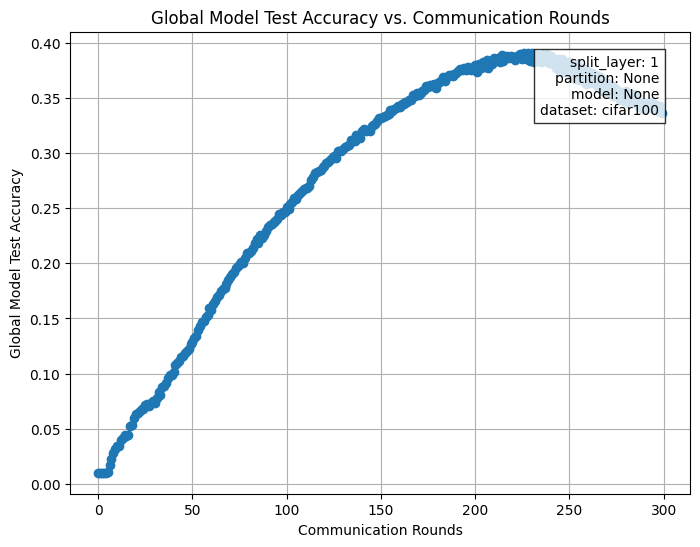

In [3]:
LOG_FILE = 'experiment_log-alg=sflv1_partition=noniid-labeldir_lr=0.001_epochs=5_num_users=100_beta=0.1_batch_size=64_opt=adam_dataset=cifar100_2024-04-15-1441-31.log'
generate_graph(LOG_FILE)

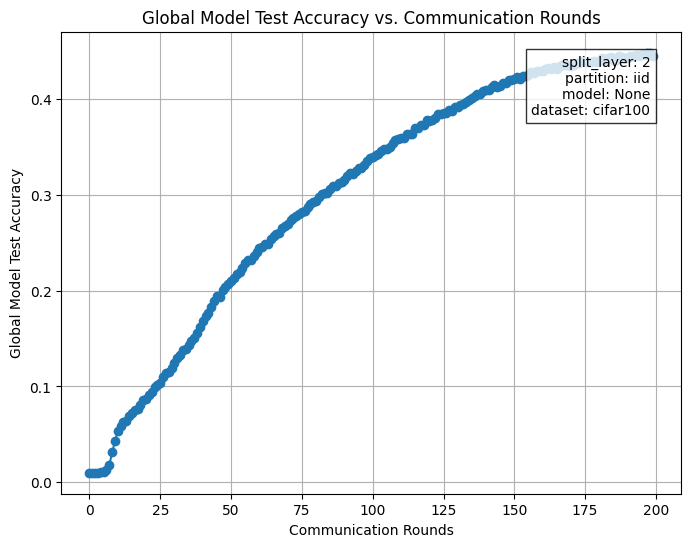

In [4]:
LOG_FILE = "experiment_log-alg=sflv1_partition=iid_lr=0.001_epochs=5_num_users=100_beta=0.01_batch_size=64_opt=adam_dataset=cifar100_2024-04-12-1050-51.log"
generate_graph(LOG_FILE)

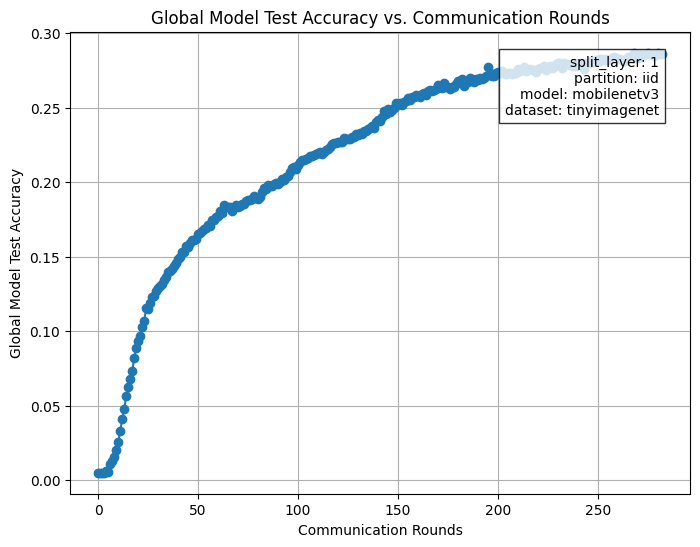

In [6]:
LOG_FILE = 'experiment_log-alg=sflv1_partition=iid_lr=0.001_epochs=5_num_users=100_beta=0.01_batch_size=64_opt=adam_dataset=tinyimagenet_2024-04-18-1427-39.log'
generate_graph(LOG_FILE)